## Семинар 9: Квантильная регрессия

# Задача 1 L1-регрессия

Или робастные оценки линейной регрессии (min MAE)


$\sum_i |\epsilon_i| → min $

Датасет:
$y_1 = 1, x_1 = 2$;
$y_2 = 2, x_2 = \frac{1}{2}$;
$y_3 = -1, x_3 = -3$;

Рассмотрим предсказание медианной регрессии:

$\hat{y_i} = \beta_0 + \beta_1 x_i$


Мы хотим минимизировать сумму остатков модели:
 $\sum_i |\epsilon_i| = |1- \beta_0 - 2 \beta_1  |+ |2- \beta_0 - \frac{1}{2} \beta_1  |+ |-1- \beta_0 +3 \beta_1 |$




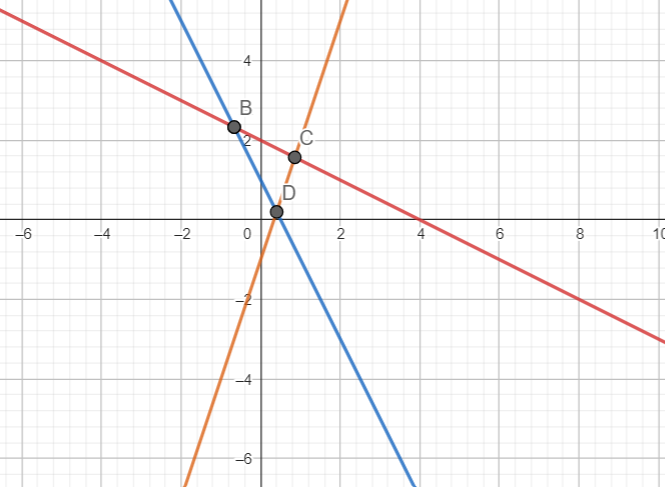

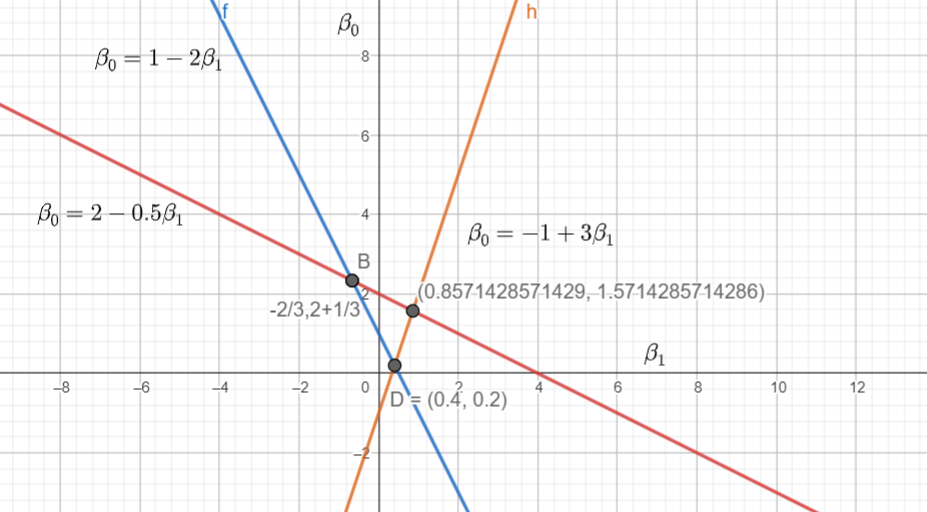

Как можно решить прелставим в виде задаче линейного программирования, раскрывая модуль(так как ограничения и оптимизируемый функционал линейны):

$\sum_i \epsilon_i → min $

s.t $\epsilon_i \leq (y_i - \beta_0 - \beta_1 x_i)$
or $\epsilon_i \ge (-y_i+ \beta_0 + \beta_1 x_i)$


Найдем все точки пересечения:



1.  $1- \beta_0 - 2 \beta_1 =0$ и прямой $2- \beta_0 - \frac{1}{2} \beta_1 = 0$



2.   $1- \beta_0 - 2 \beta_1 =0$ и прямой $-1- \beta_0 +3 \beta_1 = 0$



3.  $-1- \beta_0 +3 \beta_1=0$ и прямой $2- \beta_0 - \frac{1}{2} \beta_1 = 0$


In [ ]:
# solve linear system but alc determinant to verify that the lines are not paralel

Задача линейного программирования

$$min \sum_{i=1}{c_i x_i}$$

$$\sum_{j}a_{ji} x_i\ge b_i(i=1,2,..m)$$

$$x_i \ge 0$$

Как решается?
Так как функционал линейный и ограничения линейны, то производные по параметрам $x_i$ будет константами и мы не найдем   комбинацию $x_i$ которая обратит все производные в ноль. Поэтому точка минимума будет на границе этого множества ограничений.

Поэтому среди всех точек пространства допустимых решений будем искать точке на  границы этого пространства как пересечения двух ограничений $$\sum_{j}a_{ji} x_i\ge b_i(i=1,2,..n)$$


Решение перебор точек пересечения и расчет функции потерь

In [ ]:
import numpy as np
# обучающая выборка
X = np.array([2,0.5,-3])

# таргеты
y =  np.array([1,2,-1])

def sum_modulus_eps(X, y, beta):
  # оптимизируемый функционал
  return np.sum(np.abs(y - beta[0] - beta[1]*X))

def solve_system(col1, col2):
    # решение задачи линейного программирования как перебор значений функционала при пересечении 2 прямых
    A_matrix = np.array([ [1,1], [X[col1], X[col2]]]).T
    c_vector = np.array([y[col1],y[col2]])
    # проверка, что 2 прямые пересекаются
    if np.linalg.det(A_matrix)!=0:
      # находим точку пересечения, решая линейную систему уравнений
      beta_intercept = np.linalg.inv(A_matrix)@c_vector
      return [True, beta_intercept]
    else:
      return [False]

max_sum_abs =  0
best_beta = [0,0]
# Итерируемся по всем возможным сочетаниям пар прямых
for col1 in range(len(y)):
  for col2 in range(len(y)):
    # O(n^2)
    intercetion = solve_system(col1, col2)
    if intercetion[0]:
       sum_abs = sum_modulus_eps(X, y, intercetion[1])
       if sum_abs > max_sum_abs:
        max_sum_abs = sum_abs
        best_beta = intercetion[1]

print('max_sum_abs = ', max_sum_abs)
print("best_beta = ", best_beta)

max_sum_abs =  5.333333333333334
best_beta =  [ 2.33333333 -0.66666667]


Maximum at point B

Задачи линейного программирования в более высокой размерности можно решать  с помощью симлекс метода

Ваши предложения по эффективности кода)

#Задача 2 Квантильная регрессия


In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import pandas as pd
data = pd.read_csv("https://gist.githubusercontent.com/sachinsdate/402daa205e93a389d0f7023439588774/raw/43822519a8d99b038c338a476b063a04fb1c44f2/automobiles_dataset_subset_uciml.csv")

In [ ]:
data.head()

,make,aspiration,body_style,curb_weight,num_of_cylinders,engine_size,price
0,alfa-romero,std,convertible,2548,4,130,13495
1,alfa-romero,std,convertible,2548,4,130,16500
2,alfa-romero,std,hatchback,2823,6,152,16500
3,audi,std,sedan,2337,4,109,13950
4,audi,std,sedan,2824,5,136,17450


In [ ]:
data.num_of_cylinders.value_counts()

4     157
6      24
5      10
2       4
8       4
3       1
12      1
Name: num_of_cylinders, dtype: int64

Предположим, мы хотим предсказывать по количеству цилиндров в двигателе автомобиля цену автомобиля

Мы хотим посмотреть на условное матожидание цены по количеству цилиндров.

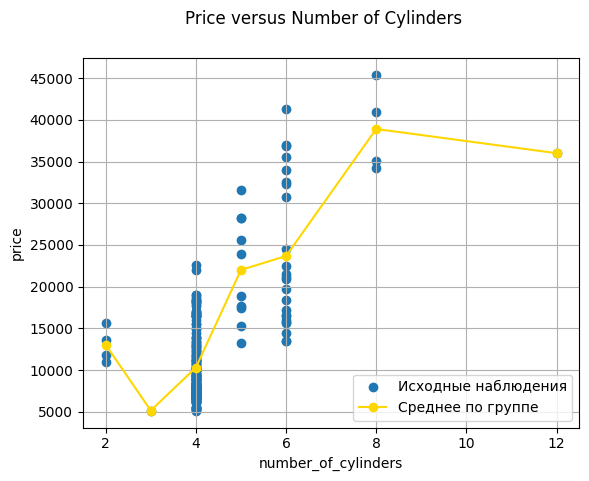

In [ ]:

fig = plt.figure()
fig.suptitle('Price versus Number of Cylinders')

plt.xlabel('number_of_cylinders')
plt.ylabel('price')

plt.scatter(x=data['num_of_cylinders'], y=data['price'], label='Исходные наблюдения')

num_of_cylinders = np.array(data.groupby('num_of_cylinders')['num_of_cylinders'].mean())

conditional_means = np.array(data.groupby('num_of_cylinders')['price'].mean())

plt.plot(num_of_cylinders, conditional_means, color='gold', marker='o', label='Среднее по группе')
plt.legend()
plt.grid()

plt.show()

Давайте сравним модель линейной регрессии $Price_i = \beta_0+\beta_1 NumOfCylinders_i +ɛ_i$ с условном матожидание цены по количеству цилиндров E(Price|NumOfCylinders)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     200.7
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           5.73e-32
Time:                        10:37:39   Log-Likelihood:                -2019.7
No. Observations:                 201   AIC:                             4043.
Df Residuals:                     199   BIC:                             4050.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -9985.9377   1684.299  

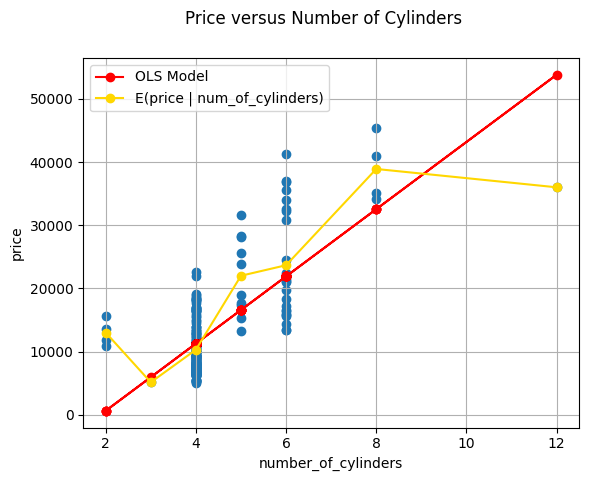

In [ ]:
reg_exp = 'price ~ num_of_cylinders'
y_train, X_train = dmatrices(reg_exp, data, return_type='dataframe')
#Build and train an OLS regression model
olsr_model = sm.OLS(endog=y_train, exog=X_train)
olsr_model_results = olsr_model.fit()
print(olsr_model_results.summary())

#Plot the OLS regression line on the scatter plot of Price versus num_of_cylinders
fig = plt.figure()
fig.suptitle('Price versus Number of Cylinders')
plt.xlabel('number_of_cylinders')
plt.ylabel('price')
plt.scatter(x=data['num_of_cylinders'], y=data['price'])

#Get the estimated conditional means from the trained OLS model
y_pred_ols = olsr_model_results.predict(X_train)

#Plot the estimated conditional means
ols, = plt.plot(X_train['num_of_cylinders'], y_pred_ols,
    color='red', marker='o', linestyle='solid', label='OLS Model')

#Also plot the observed conditional means i.e. E(price | num_of_cylinders)
plt.plot(num_of_cylinders, conditional_means, color='gold', marker='o', label='E(price | num_of_cylinders)')
plt.legend()
plt.grid()
plt.legend()

plt.show()

Видно  что оценка регрессии сильно отличается от условного матожидания.


Давайте посмотрим на медианную регрессию:

Но в некоторых наборах данных среднее значение не является хорошим образцом.

Вот три примера наборов данных, для которых среднее значение может оказаться неподходящей статистикой для оценки:

* Данные сильно искажены влево или вправо. Так часто бывает с данными о страховых возмещениях или расходах на здравоохранение, где большинство требований оцениваются незначительно, но данные имеют длинный хвост требований с растущей стоимостью.


* Данные являются мультимодальными, т.е. они имеют более одного очень часто встречающегося значения. Например, если данные содержат два примерно одинаковых пика (бимодальный набор данных), модель среднего значения оценит точку внутри долины между двумя пиками, которая не является хорошим представителем данных.


*  Данные содержат значимые выбросы. Регрессионные модели, такие как обычная регрессионная модель наименьших квадратов, которые основаны на минимизации суммы квадратов остаточных ошибок, очень чувствительны к наличию выбросов. В таких случаях может оказаться полезным минимизировать сумму абсолютных значений остаточных ошибок в дополнение к отказу от использования среднего значения в качестве величины, подлежащей оценке.
Во всех этих случаях среднее значение неадекватно отражает характер данных. Возможно, было бы лучше оценить условную медиану.



В самых общих чертах наша регрессионная модель “поиска медианы” была бы определена следующим уравнением:
$Median(y|x_i) =  m(\hat{\beta}, x_i) = \hat{\beta_0}+\hat{\beta_1}x_i$, при условии что
$P(x\leq m(\hat{\beta}, x_i)) = 0,5$




Мы начнем с обучения модели, которая будет оценивать условную медиану, а именно median(price|num_of_cylinders).

Давайте создадим экземпляр модели квантильной регрессии следующим образом:

In [ ]:
median_model = smf.quantreg(formula=reg_exp, data=data)
median_model_results = median_model.fit(q=0.5)

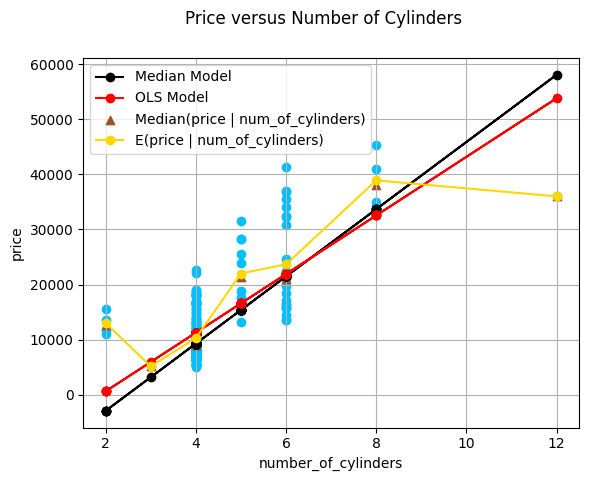

In [ ]:

fig = plt.figure()

fig.suptitle('Price versus Number of Cylinders')

plt.xlabel('number_of_cylinders')
plt.ylabel('price')

#Show the scatter plot of price versus num_of_cylinders
plt.scatter(x=data['num_of_cylinders'], y=data['price'], c='deepskyblue')

#Get the estimated conditional medians from the median model
y_pred_median = median_model_results.predict(X_train)

#Plot the estimated conditional medians
median, = plt.plot(X_train['num_of_cylinders'], y_pred_median,
    color='black', marker='o', linestyle='solid',  label='Median Model')

#For comparison, also plot the estimated conditional means from the OLS model we built earlier
ols, = plt.plot(X_train['num_of_cylinders'], y_pred_ols,
    color='red', marker='o', linestyle='solid',  label='OLS Model')

#Calculate the observed conditional medians
conditional_medians = np.array(data.groupby('num_of_cylinders')['price'].median())

#Plot the observed conditional medians
conditional_median_pts = plt.scatter(x=num_of_cylinders, y=conditional_medians, c='sienna', marker='^', label='Median(price | num_of_cylinders)')

#For comparison, plot the observed conditional means
plt.plot(num_of_cylinders, conditional_means, color='gold', marker='o', label='E(price | num_of_cylinders)')

#Set up the legend and show the plot
plt.legend()
plt.grid()
plt.show()

Такую постановку можно обобщить на случай любой квантили $q$.
Так мы получим квантильную регрессию:
$Quantile(y|x_i) =  f_q(\hat{\beta}, x_i) = \hat{\beta_0}+\hat{\beta_1}x_i$, при условии что
$P(x\leq f_q(\hat{\beta}, x_i)) = 0,5$


Давайте также построим линии регрессии для нескольких других квантильных точек, скажем, [0.1, 0.25, 0.5, 0.75, 0.9].

                         QuantReg Regression Results                          
Dep. Variable:                  price   Pseudo R-squared:               0.1868
Model:                       QuantReg   Bandwidth:                       3974.
Method:                 Least Squares   Sparsity:                    1.218e+04
Date:                Sat, 18 Nov 2023   No. Observations:                  201
Time:                        10:38:39   Df Residuals:                      199
                                        Df Model:                            1
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -8206.5000   1748.197     -4.694      0.000   -1.17e+04   -4759.131
num_of_cylinders  3683.8750    402.717      9.148      0.000    2889.735    4478.015
                         QuantReg Regression Results                          
Dep. Variable:              

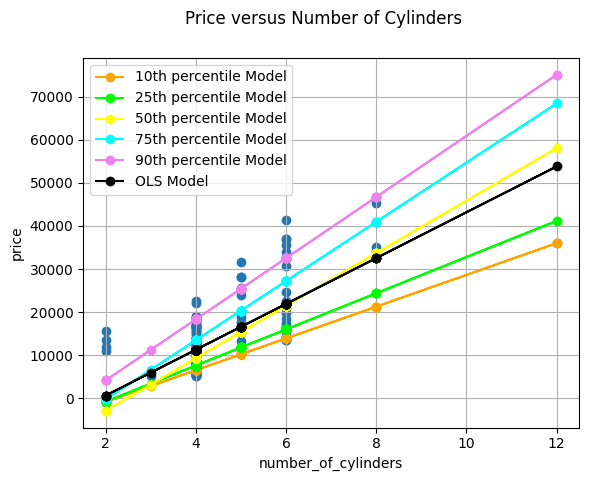

In [ ]:

fig = plt.figure()

fig.suptitle('Price versus Number of Cylinders')

plt.xlabel('number_of_cylinders')
plt.ylabel('price')

plt.scatter(x=data['num_of_cylinders'], y=data['price'])

coeff = []
colors = ['orange', 'lime', 'yellow', 'cyan', 'violet']
i=0
handles = []
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

for q in quantiles:
    #Build the model
    quantile_model = smf.quantreg(formula=reg_exp, data=data)

    #Fit the model
    quantile_model_results = quantile_model.fit(q=q)

    print(quantile_model_results.summary())

    coeff.append(quantile_model_results.params['num_of_cylinders'])

    #Get the estimated values from the quantile model
    y_pred_quantile = quantile_model_results.predict(X_train)

    #Plot the estimated values
    quantile, = plt.plot(X_train['num_of_cylinders'], y_pred_quantile, color=colors[i], marker='o', linestyle='solid',  label=str(int(q*100))+'th percentile Model')

    i = i+1
    handles.append(quantile)

#Also plot the estimated values from the OLS model for comparison
ols, = plt.plot(X_train['num_of_cylinders'], y_pred_ols,
    color='black', marker='o', linestyle='solid', label='OLS Model')

handles.append(ols)
plt.legend(handles=handles)
plt.grid()
plt.show()

Посмотрим как с изменинием квантили в квантильной регрессии изменялся коэффициент при num_of_cylinders

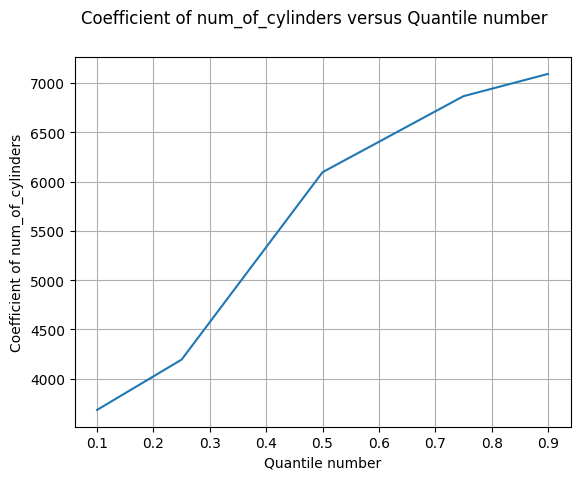

In [ ]:
#Plot the coefficient of num_of_cylinders versus quantile number
fig = plt.figure()
fig.suptitle('Coefficient of num_of_cylinders versus Quantile number')
plt.xlabel('Quantile number')
plt.ylabel('Coefficient of num_of_cylinders')
plt.plot(quantiles, coeff)
plt.grid()
plt.show()

This exercise is based on [tutorial](https://timeseriesreasoning.com/contents/introduction-to-the-quantile-regression-model/)

# Синтетический пример для понимания квантильной регрессии

$L = \sum\limits_{i=1}^{n} \rho_{\tau} (y_i - x_i \beta_{\tau}) \to min$

$\rho_{\tau} = \tau, y_i > x_i \beta_{\tau}$

$\rho_{\tau} = \tau-1, y_i \le x_i \beta_{\tau}$

$L = \sum\limits_{y_i > x_i \beta_{\tau}} \tau (y_i - x_i \beta_{\tau}) + \sum\limits_{y_i <= x_i \beta_{\tau}} (\tau-1) (y_i - x_i \beta_{\tau}) \to min$

In [ ]:
X_train = np.vstack([np.ones(10), np.arange(10)+1])
X_train

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]])

In [ ]:
X_train = np.vstack([np.ones(10), np.arange(10)+1]).T
Y_train = np.array([1, 1, 1, 1, 2, 3, 5, 30, 36, 40])

olsr_model = sm.OLS(endog=Y_train, exog=X_train)
olsr_model_results = olsr_model.fit()
print(olsr_model_results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     20.41
Date:                Sat, 18 Nov 2023   Prob (F-statistic):            0.00196
Time:                        10:27:04   Log-Likelihood:                -35.252
No. Observations:                  10   AIC:                             74.50
Df Residuals:                       8   BIC:                             75.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.1333      6.276     -2.093      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


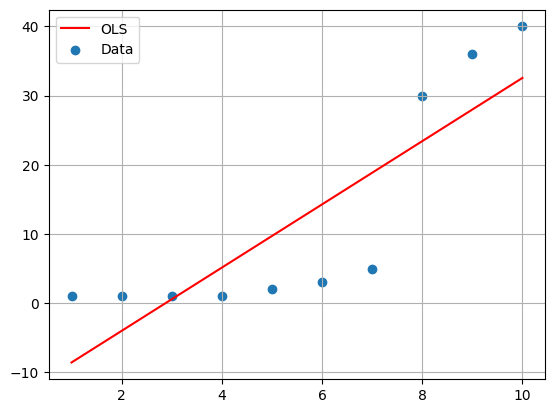

In [ ]:
plt.figure()
plt.plot(X_train[:, 1], olsr_model_results.predict(X_train), label='OLS', color='red')
plt.scatter(X_train[:, 1], Y_train, label='Data')
plt.grid()
plt.legend()
plt.show()

## q 0.8

In [ ]:
sum(olsr_model_results.resid[olsr_model_results.resid>0] * 0.8) - sum(olsr_model_results.resid[olsr_model_results.resid<=0] * 0.2)

36.99999999999996

In [ ]:
y_tau_80 = X_train @ np.array([0, 4])
e_tau = Y_train-y_tau_80
print(e_tau)
sum(e_tau[e_tau>0] * 0.8) - sum(e_tau[e_tau<=0] * 0.2)

[ -3.  -7. -11. -15. -18. -21. -23.  -2.   0.   0.]


20.0

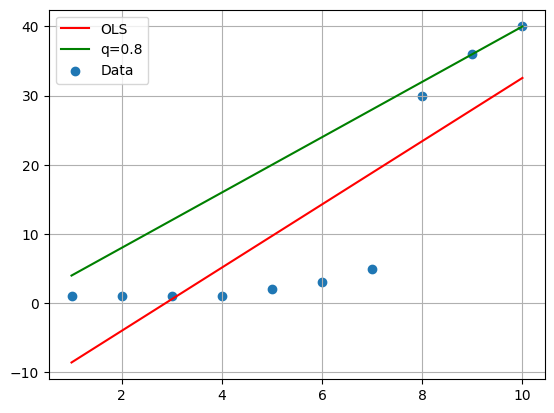

In [ ]:
plt.figure()
plt.plot(X_train[:, 1], olsr_model_results.predict(X_train), label='OLS', color='red')
plt.plot(X_train[:, 1], y_tau_80, label='q=0.8', color='green')

plt.scatter(X_train[:, 1], Y_train, label='Data')
plt.grid()
plt.legend()
plt.show()

## q 0.2

In [ ]:
sum(olsr_model_results.resid[olsr_model_results.resid>0] * 0.2) - sum(olsr_model_results.resid[olsr_model_results.resid<=0] * 0.8)

37.00000000000002

In [ ]:
y_tau_20 = X_train @ np.array([2, 0.1])
e_tau = Y_train-y_tau_20
print(e_tau)
sum(e_tau[e_tau>0] * 0.2) - sum(e_tau[e_tau<=0] * 0.8)

[-1.1 -1.2 -1.3 -1.4 -0.5  0.4  2.3 27.2 33.1 37. ]


24.4

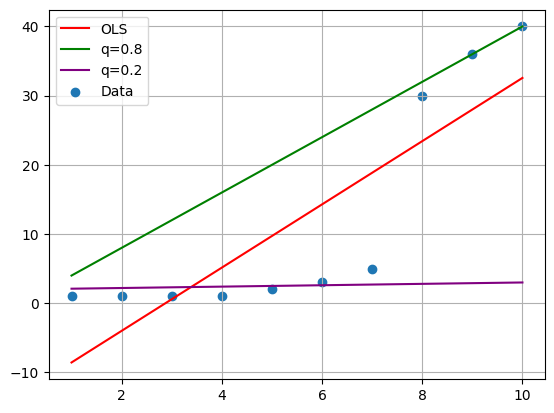

In [ ]:
plt.figure()
plt.plot(X_train[:, 1], olsr_model_results.predict(X_train), label='OLS', color='red')
plt.plot(X_train[:, 1], y_tau_80, label='q=0.8', color='green')
plt.plot(X_train[:, 1], y_tau_20, label='q=0.2', color='purple')
plt.scatter(X_train[:, 1], Y_train, label='Data')
plt.grid()
plt.legend()
plt.show()

* $x<7.5 \to$ q0.2-regression
* $x>=7.5 \to$ q0.8-regression